# 1. 라이브러리 임포트 및 폰트 설정

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import matplotlib.font_manager as fm
import seaborn as sns
import matplotlib as mpl

In [2]:
font_path = "/System/Library/Fonts/Supplemental/AppleGothic.ttf"
fontprop = fm.FontProperties(fname=font_path)
font_name = fontprop.get_name()
mpl.rcParams['font.family'] = font_name
mpl.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")
plt.rcParams['font.family'] = font_name

# 2. 데이터셋 전처리

In [3]:
df = pd.read_csv("./sensor_data_pivot.csv", parse_dates=['time'])

## 특성공학 (area 매핑 및 파생 변수 생성)

In [4]:
area_map = {
    "8인 책상": 64.65,
    "왼쪽 뒤": 109.21,
    "안쪽벽 중앙": 25.13,
    "보드": 31.59
}
df['area'] = df['location'].map(area_map)
df = df.dropna(subset=['area'])
df['co2_per_area'] = df['co2'] / df['area']

## 결측치 처리

In [5]:
imputer = IterativeImputer(random_state=42)
df[['co2', 'temperature', 'humidity']] = imputer.fit_transform(
    df[['co2', 'temperature', 'humidity']]
)
df = df.dropna(subset=['co2_per_area'])

## 데이터 증강 (덥고 습함, 춥고 건조)

In [6]:
def gen_proto(n, mean, std, areas):
    df_s = pd.DataFrame({
        'co2': np.random.normal(mean[0], std[0], n),
        'temperature': np.random.normal(mean[1], std[1], n),
        'humidity': np.random.normal(mean[2], std[2], n),
    })
    df_s['co2_per_area'] = df_s['co2'] / np.random.choice(areas, n)
    return df_s

areas = df['area'].unique()
specs = [
    ([850, 19, 35], [200, 1, 5]),   # 춥고 건조
    ([1200, 27, 65], [300, 1, 5])   # 덥고 습함
]
synth = pd.concat([gen_proto(2000, m, s, areas) for m, s in specs], ignore_index=True)
df = pd.concat([df, synth], ignore_index=True)

df.head()

,time,location,co2,humidity,temperature,area,co2_per_area
0,2025-04-25 00:05:00+00:00,8인 책상,481.400000,25.6,23.660000,64.65,7.446249
1,2025-04-25 00:05:00+00:00,보드,562.000000,41.5,23.600000,31.59,17.790440
2,2025-04-25 00:05:00+00:00,왼쪽 뒤,556.000000,35.0,23.166667,109.21,5.091109
3,2025-04-25 00:10:00+00:00,8인 책상,491.800000,26.6,23.780000,64.65,7.607115
4,2025-04-25 00:10:00+00:00,보드,550.333333,41.5,23.533333,31.59,17.421125


## 데이터 정제

In [7]:
# 불필요 컬럼 제거 
df = df.drop(columns=['time', 'location', 'area'])

# 이상치 제거 (1~99 백분위 컷)
for col in ['temperature', 'humidity', 'co2_per_area']:
    lo, hi = df[col].quantile([0.01, 0.99])
    df[col] = df[col].clip(lo, hi)

# 특성 행렬 구성 및 스케일링
features = ['co2', 'temperature', 'humidity', 'co2_per_area']
X = df[features].copy()
scaler = StandardScaler()
X = scaler.fit_transform(X)


# 3. 클러스터링 분석 - 최적 k 탐색

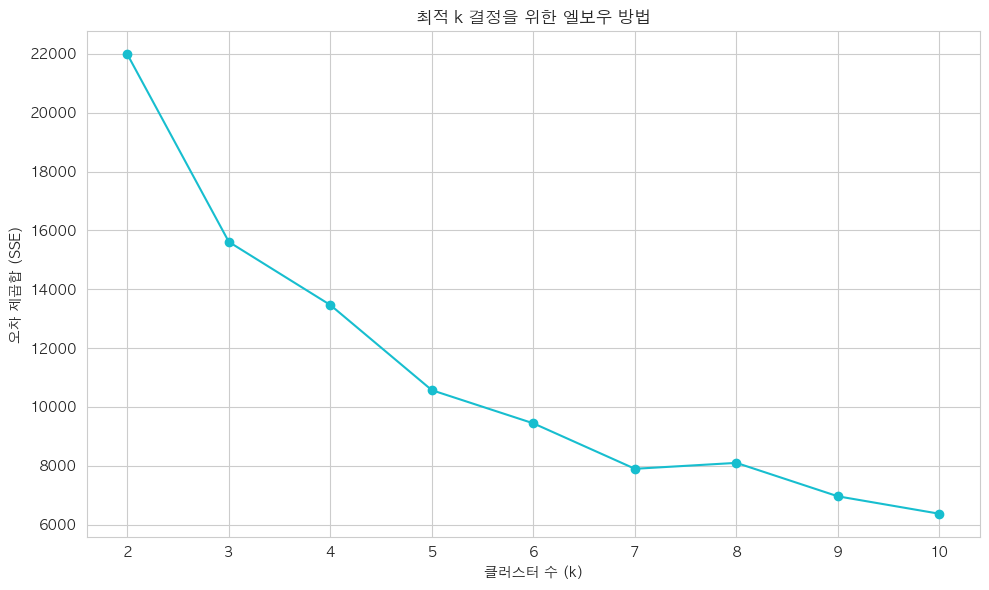

In [8]:
## 최적 k 탐색 - 엘보우
Ks = range(2, 11)
sse = []
for k in Ks:
    km = KMeans(n_clusters=k, init='k-means++', random_state=42, algorithm="elkan")
    km.fit(X)
    sse.append(km.inertia_)

# 엘보우 곡선 시각화
plt.figure(figsize=(10, 6))
plt.plot(Ks, sse, marker='o', color='#17becf')
plt.xlabel('클러스터 수 (k)')
plt.ylabel('오차 제곱합 (SSE)')
plt.title('최적 k 결정을 위한 엘보우 방법')
plt.grid(True)
plt.tight_layout()
plt.show()

# 시각화 결과 분석 및 최적 k 선택
# 그래프를 보면 k=3 또는 k=4에서 곡선의 기울기가


그래프에서 '엘보우 포인트'(곡선이 급격히 꺾이는 지점)를 찾아야 하는데 k=3에서 첫 번째 큰 기울기 변화가 나타나고, k=4에서도 어느 정도 기울기 변화가 있습니다.
k=3 이후로는 SSE(오차 제곱합)의 감소율이 완만해지는 것을 볼 수 있습니다.

k=3을 선택하면 모델이 단순하고 해석하기 쉬운 장점이 있으며, k=4를 선택하면 조금 더 세분화된 클러스터링이 가능합니다. 데이터의 특성과 분석 목적을 고려했을 때, k=3이 최적의 선택입니다.

In [9]:
k_opt = 3  # 최적 k 값 선택

## 클러스터링 수행
km = KMeans(n_clusters=k_opt, init='k-means++', random_state=42, algorithm="elkan")
labels = km.fit_predict(X)
df['cluster'] = labels

## 클러스터 중심 분석
centers_orig = scaler.inverse_transform(km.cluster_centers_)
centers = pd.DataFrame(centers_orig, columns=features)


# 4. 결과 해석

In [10]:
# 클러스터 라벨링
prototypes = {
    '최적 쾌적': np.array([650, 23, 45]),
    '춥고 건조': np.array([850, 19, 35]),
    '덥고 습함': np.array([1200, 27, 65]),
}

labels_map = {}
for i, row in centers.iterrows():
    dist = {
        name: 0.4*(row['co2']-p[0])**2
             + 0.3*(row['temperature']-p[1])**2
             + 0.3*(row['humidity']-p[2])**2
        for name, p in prototypes.items()
    }
    labels_map[i] = min(dist, key=dist.get)

df['cluster_label'] = df['cluster'].map(labels_map)
df['co2_status'] = np.where(df['co2'] > 1000, 'CO2 주의', 'CO2 양호')

Silhouette Score: 0.43322031931431093

Cluster Centers (original scale):
           co2  temperature   humidity  co2_per_area
0   864.533349    18.981945  34.886271     16.424766
1  1229.606094    26.885933  64.161565     22.652633
2   604.516147    23.969776  36.969970     11.631529

Cluster Sizes:
cluster_label
최적 쾌적    6113
덥고 습함    2014
춥고 건조    1971
Name: count, dtype: int64

CO2 Status by Cluster:
cluster_label  co2_status
덥고 습함          CO2 양호         448
               CO2 주의        1566
최적 쾌적          CO2 양호        5872
               CO2 주의         241
춥고 건조          CO2 양호        1497
               CO2 주의         474
dtype: int64


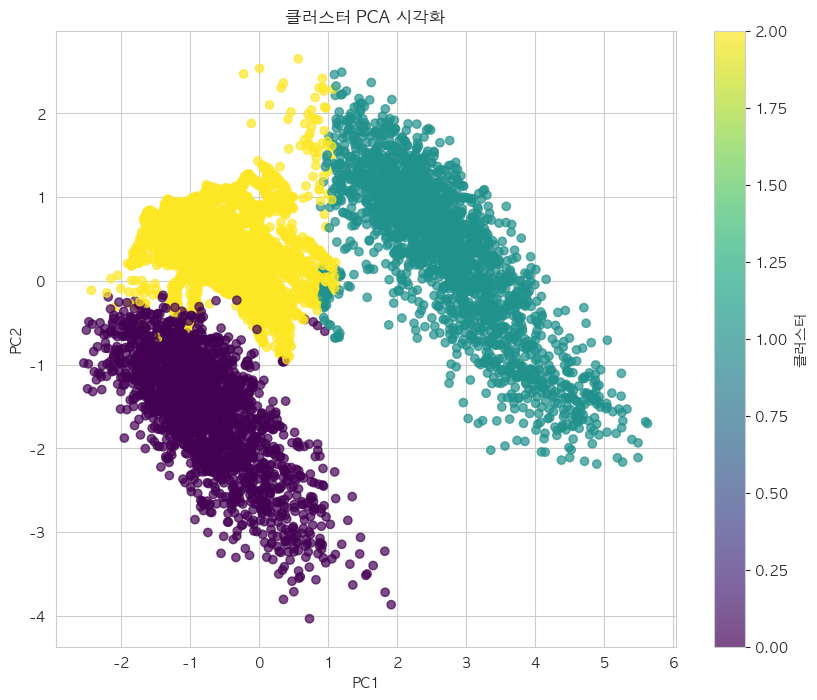

In [ ]:
## 평가 지표 및 결과 출력
sil_score = silhouette_score(X, labels)
print("Silhouette Score:", sil_score)
print("\nCluster Centers (original scale):")
print(centers)
print("\nCluster Sizes:")
print(df['cluster_label'].value_counts())
print("\nCO2 Status by Cluster:")
print(df.groupby(['cluster_label','co2_status']).size())

## PCA 시각화 (필요시)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='viridis', alpha=0.7)
plt.title('클러스터 PCA 시각화')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='클러스터')
plt.show()